In [1]:
#Importing packages
import json
import random
import re
import os
import sys
import collections
import nltk
import tqdm
import itertools
import string
import math
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy as sp
from scipy import sparse
import os.path
import unicodedata



from tqdm import tqdm, trange
from collections import Counter
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer

tokenizer = RegexpTokenizer(r'\w+')

# Question 1

In [2]:
list_of_wiki = os.listdir("data_files/wiki-pages/wiki-pages/")

In [21]:
#Question 1

#Counting frequency of every term
word_count = {}

brackets = ['lrd', 'rrb', 'lsb', 'rsb']

for file in tqdm(list_of_wiki, position = 0, leave = True):
    with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
            for iline, line in enumerate(openfile.readlines()):
                text = json.loads(line)['text']
                text = text.lower()
                tokens = tokenizer.tokenize(text)

                for token in tokens:
                    if token not in brackets:
                        if token in word_count:
                            word_count[token] += 1

                        else:
                            word_count[token] = 1

100%|██████████| 109/109 [06:13<00:00,  3.43s/it]


In [9]:
pickle.dump(word_count, open("pkl_files/word_count.p", "wb"))

In [3]:
word_count = pickle.load( open( "pkl_files/word_count.p", "rb" ) )

In [4]:
#Cell to calculate total number of words
word_ranks = list(word_count.items())
word_ranks.sort(key=lambda tup: tup[1], reverse = True) 
word_ranks

total = sum(word_count.values())
total

457271337

In [5]:
#Cell to calculate proportion of most frequent words

prop_list = []

for word, count in word_ranks[:5]:
    prop = (count/total) * 100
    prop_list.append((word, prop))
    
prop_list

[('the', 6.728126937026888),
 ('of', 3.5237113495263754),
 ('in', 3.1868513989102274),
 ('and', 2.7821435481752053),
 ('a', 2.385506179233797)]

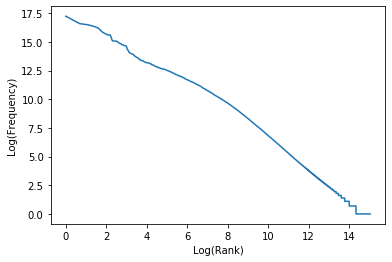

In [6]:
#Plotting curve for zipfs law
counts = list(word_count.values())
counts.sort(reverse = True)

#Making a log version of lists
log_freq = []
log_ranks = []

for count in counts:
    log_freq.append( math.log(count))
    
for rank in range(1,len(log_freq) + 1):
    log_ranks.append(math.log(rank))
 
    
f = plt.figure()
plt.plot(log_ranks, log_freq)
plt.xlabel('Log(Rank)')
plt.ylabel('Log(Frequency)')
plt.show()

In [7]:
#Calculating value of constant K

log_sums = []

for idx, val in enumerate(log_freq):

    item_sum = log_freq[idx] + log_ranks[idx]
    log_sums.append(item_sum)
    
avg_k = sum(log_sums)/len(log_sums)
avg_k

14.977259523130932

In [8]:
math.exp(avg_k)

3195517.239955811

[0, 3300000, 0, 30]

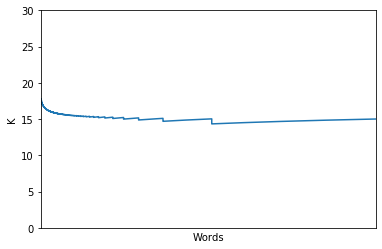

In [9]:
#Plotting K across range of values
plt.plot(log_sums)
plt.xlabel('Words')
plt.ylabel('K')
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.axis([0, 3300000, 0, 30])

# Question 2

###  Making a list of all words in the claims and stemming and removing stop words

In [10]:
claims = []

ten_claims =  [75397,150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]
claim_string = []

with open('data_files/train.jsonl') as openfile:
        for iline, line in enumerate(openfile.readlines()):
        
            claim_dic = json.loads(line)
            ID = claim_dic['id']
            
            
            if ID in ten_claims:
                claim_string.append(claim_dic['claim'])
                text = claim_dic['claim'].lower()
                tokens = tokenizer.tokenize(text)
                
                claims.append(tokens)
                
#All claim words
all_words = []

for claim in claims:
    for word in claim:
        all_words.append(word)
        
#Removing stop words from claims
stop_words = set(stopwords.words('english')) 
stemmer = PorterStemmer()

all_words = [word for word in all_words if not word in stop_words] 
all_words = [stemmer.stem(word) for word in all_words]

all_words = list(set(all_words))
all_words.sort()

### Constructing TF matrix

In [45]:
total_docs = 0
for file in tqdm(list_of_wiki, position = 0, leave = True):
        with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
                for iline,line in enumerate(openfile.readlines()):
                    total_docs += 1

100%|██████████| 109/109 [00:10<00:00, 10.36it/s]


In [47]:
tf_matrix = np.zeros((total_docs, len(all_words)))
doc_lengths = []
ids = []
current_doc = 0

brackets = ['lrb', 'rrb', 'lsb', 'rsb', 'rcb', 'lcb']

for file in tqdm(list_of_wiki, position = 0, leave = True):
        with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
                for iline,line in enumerate(openfile.readlines()):
                    
                    text = json.loads(line)['text']
                    text = text.lower()
                    tokens = tokenizer.tokenize(text)
                    
                    #Removing stop words
                    tokens = [word for word in tokens if not word in stop_words] 
                    
                    #Removing brackets manually
                    tokens = [word for word in tokens if not word in brackets] 
                    
                    #Stemming
                    tokens = [stemmer.stem(word) for word in tokens]
                    
                    #Appending doc_lengths
                    doc_lengths.append(len(tokens))
                    
                    #Count the words in documents
                    for ind,word in enumerate(all_words):
                        if word in set(tokens):
                            word_tf = tokens.count(word)/len(tokens)
                            tf_matrix[current_doc][ind] = word_tf
                                
                    ids.append(json.loads(line)['id'])
                    current_doc += 1

100%|██████████| 109/109 [1:42:47<00:00, 56.58s/it]


### Saving and loading in files to save time in the future.

In [48]:
pickle.dump(ids, open("pkl_files/ids.p", "wb"))

In [11]:
ids = pickle.load( open( "pkl_files/ids.p", "rb" ) )

In [50]:
pickle.dump(doc_lengths, open("pkl_files/doc_lengths.p", "wb"))

In [12]:
doc_lengths = pickle.load( open( "pkl_files/doc_lengths.p", "rb" ) )

In [52]:
file_path = "pkl_files/tf_matrix.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

bytes_out = pickle.dumps(tf_matrix)
with open(file_path, 'wb') as f_out:
    for idx in range(0, len(bytes_out), max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])

In [13]:
file_path = "pkl_files/tf_matrix.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
tf_matrix = pickle.loads(bytes_in)

### Constructing IDF matrix

In [14]:
total_doc = tf_matrix.shape[0]

In [15]:
#Making IDF matrix

#Counting number of documents with each term in it
idf_matrix = np.zeros(len(all_words))

for index in range(0, len(all_words)):
    doc_count = np.count_nonzero(tf_matrix[:,index])
    idf_matrix[index] = math.log10(total_doc/doc_count)

In [16]:
tf_idf = tf_matrix*idf_matrix

### Constructing TF-IDF representation of claims

In [17]:
clean_claims = []

stop_words = set(stopwords.words('english')) 
stemmer = PorterStemmer()

for claim in claims:
    clean_claim = [word for word in claim if not word in stop_words] 
    clean_claim = [stemmer.stem(word) for word in clean_claim]
    clean_claims.append(clean_claim)

In [18]:
#tf_idf for every claim/norm adjusted
claims_tf_idfs = []

for claim in clean_claims:
    claim_tf = np.zeros(len(all_words))
    
    for idx, word in enumerate(all_words):
        claim_tf[idx] = claim.count(word)/len(claim)
            
    claim_tf_idf = claim_tf*idf_matrix
    claims_tf_idfs.append(claim_tf_idf)

### Calculating Cosine similarity

In [19]:
#Norm adjusting the matrices
norm_rows_docs = []
norm_rows_claims = []

for row in tf_idf:
    norm_doc = np.linalg.norm(row)
    norm_adj_row = row
    
    if norm_doc!= 0:
        norm_adj_row = norm_adj_row/norm_doc
    
    norm_rows_docs.append(norm_adj_row)
        
for claim in claims_tf_idfs:
    norm_claim = np.linalg.norm(claim)
    norm_adj_claim = claim/norm_claim
    norm_rows_claims.append(norm_adj_claim)
    
doc_norm_tf_idf = np.array(norm_rows_docs)

In [20]:
#Retrieving 5 highest for each claim
top5_list = []

for claim in norm_rows_claims:
    cosine_similarity = doc_norm_tf_idf@claim 
    highest_5_row = cosine_similarity.argsort()[-5:][::1]
    
    highest_5 = []
    for ind in highest_5_row:
        highest_5.append(ids[ind])
        
    highest_5.reverse()    
    top5_list.append(highest_5)

In [21]:
claim_disp_list = list(zip(claim_string, top5_list))

# Question 3

## Unigram

In [22]:
#Query Likelihood Model
unigram_similar = []
for claim in clean_claims:

    probabs = np.ones(tf_matrix.shape[0])
    
    for word in claim:
        position = all_words.index(word)
        vec = tf_matrix[:, position]
        probabs = probabs*vec

    highest_prob_indices = probabs.argsort()[-5:][::1]
    
    non_zero_unigram = []   
    for ind in highest_prob_indices:
        if probabs[ind]!=0:
            non_zero_unigram.append(ids[ind])
    
    non_zero_unigram.reverse()
    unigram_similar.append((claim, non_zero_unigram))

In [23]:
#Calculating returned unigrams
returned_unigram = []

for tup in unigram_similar:
    returned_unigram.append(len(tup[1]))
    
returned_unigram

[0, 0, 1, 0, 1, 5, 5, 1, 1, 5]

## Laplace Smoothing

In [24]:
laplace_similar = []
#Creating array of doc lengths to adjust tf matrix back to just count
doc_length_array = np.array(doc_lengths)

#Creating new denominator to divide by
adj_denom = doc_length_array + len(counts)
adj_denom = np.reciprocal(adj_denom.astype(np.float32))

for claim in clean_claims:

    probabs = np.ones(tf_matrix.shape[0])
    
    for word in claim:
        position = all_words.index(word)
        
        #Required modification to tf matrix
        vec = tf_matrix[:, position]
        term_freq = vec*doc_length_array
        
        term_freq_plus1 = term_freq + 1
        term_freq_div = term_freq_plus1*adj_denom
        
        #Calculating probabilities like with mle
        probabs = probabs*term_freq_div

    highest_prob_indices = probabs.argsort()[-5:][::1]
    
    #Retrieving top5 artilces
    top5_laplace = []   
    for ind in highest_prob_indices:
        top5_laplace.append(ids[ind])
    
    top5_laplace.reverse()
    laplace_similar.append((claim, top5_laplace))

## Jelinek-Mercer Smoothing

In [25]:
#Building necessary vector to represent entire corpus

#Total words
total_words = sum(counts)

#Making a stemmed word dictionary
word_count_list = list(word_count.items())

stem_word_count = {}

for word_tuple in word_count_list:
    word = word_tuple[0]
    count = word_tuple[1]
    
    stemmed_word = stemmer.stem(word)
    
    if stemmed_word in stem_word_count:
        stem_word_count[stemmed_word] += count
        
    else:
        stem_word_count[stemmed_word] = count
        
claim_word_counts = []

for word in all_words:
    claim_word_counts.append(stem_word_count[word])
    
claim_words_array = np.array(claim_word_counts)
claim_words_array_div = claim_words_array/total_words

In [26]:
#Setting lambda value
lambda_val = 0.5

#Calculating jelinek mercer similarity
jelinek_similar = []
for claim in clean_claims:

    probabs = np.ones(tf_matrix.shape[0])
    
    for word in claim:
        position = all_words.index(word)
        vec = tf_matrix[:, position]
        
        #jelinek mercer smoothing
        lam_vec = lambda_val*vec
        corpus_vec = lam_vec + ((1-lambda_val)*claim_words_array_div[all_words.index(word)])
        
        probabs = probabs*corpus_vec

    highest_prob_indices = probabs.argsort()[-5:][::1]
    
    jelinek_similar_claim = []   
    for ind in highest_prob_indices:
        jelinek_similar_claim.append(ids[ind])
    
    jelinek_similar_claim.reverse()
    jelinek_similar.append((claim, jelinek_similar_claim))

## Dirichlet Smoothing

In [27]:
#Building modified lambda value for dirichlet
avg_length = total_words/ tf_matrix.shape[0]

dirich_denom = doc_length_array + avg_length
dirich_denom = np.reciprocal(dirich_denom.astype(np.float32))

dirich_constant = doc_length_array*dirich_denom

In [29]:
dirichlet_similar = []

for claim in clean_claims:

    probabs = np.ones(tf_matrix.shape[0])
    
    for word in claim:
        position = all_words.index(word)
        vec = tf_matrix[:, position]
        
        
        dirich_vec = dirich_constant*vec
        corpus_dirich_vec = dirich_vec + ((1-dirich_constant)*claim_words_array_div[all_words.index(word)])
        
        probabs = probabs*corpus_dirich_vec

    highest_prob_indices = probabs.argsort()[-5:][::1]
    
    dirich_similar_claim = []   
    for ind in highest_prob_indices:
        dirich_similar_claim.append(ids[ind])
    
    dirich_similar_claim.reverse()
    dirichlet_similar.append((claim, dirich_similar_claim))

### Sending output to CSV files

In [31]:
ten_claims =  [75397,150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]

def csv_sender(results, ten_claims):
    
    list_of_lists =[]
    
    for result in results:
        list_of_lists.append(result[1])
        
    df = pd.DataFrame(list_of_lists)
    
    df.columns = ['doc id_1', 'doc id_2', 'doc id_3', 'doc id_4','doc id_5' ]
    df.index = ten_claims
    df.index.name = 'claim id'
        
    return(df)

csv_sender(claim_disp_list, ten_claims).to_csv('csv_files/cosine.csv')
csv_sender(unigram_similar, ten_claims).to_csv('csv_files/unigram.csv')
csv_sender(laplace_similar, ten_claims).to_csv('csv_files/laplace.csv')
csv_sender(jelinek_similar, ten_claims).to_csv('csv_files/jelinek.csv')
csv_sender(dirichlet_similar, ten_claims).to_csv('csv_files/dirichlet.csv')

# Question 4

## Part i)

In [33]:
#Loading in the glove model

def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

model = loadGloveModel('glove.6B.50D.txt')

Loading Glove Model
Done. 400000  words loaded!


### Loading in document lines for specific claim

In [35]:
#Setting the claim to check
claim_to_check = dirichlet_similar[0]
claim_to_check

(['nikolaj', 'coster', 'waldau', 'work', 'fox', 'broadcast', 'compani'],
 ['New_Amsterdam_-LRB-TV_series-RRB-',
  'Nikolaj_Coster-Waldau',
  'The_Other_Woman_-LRB-2014_film-RRB-',
  'Ved_verdens_ende',
  'Nukaaka_Coster-Waldau'])

In [36]:
#Loading in lines from relevant documents

lines_from_doc = []

bracket_dict = {'-lrb-': '(', '-rrb-': ')', '-lsb-': '[', '-rsb-': ']', '-lcb': '{', 'rcb': '}'}

for file in tqdm(list_of_wiki):
        with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
                for iline,line in enumerate(openfile.readlines()):
                    iD = json.loads(line)['id']
                    
                    if iD in claim_to_check[1]:
                        doc_lines = json.loads(line)['lines']
                        doc_line_list = doc_lines.split('\n')
                        
            
                        for doc_line in doc_line_list:
                            doc_line = doc_line.lower()
                            #Isolating cleaned up version of line
                            doc_line = doc_line.split('\t')[1]
                            doc_line = doc_line.split('.')[0]
                            
                            doc_line = doc_line.split(' ')
                            
                            doc_line = doc_line[:-1]
                            
                            #Sorting out the brackets
                            doc_line_brac = []
                            for word in doc_line:
                                
                                if word in set(list(bracket_dict.keys())):
                                    word = bracket_dict[word]
                                
                                doc_line_brac.append(word)
                                
                        #doc_tokens = nltk.word_tokenize(doc_lines)
                            lines_from_doc.append(doc_line_brac)

100%|██████████| 109/109 [00:54<00:00,  2.01it/s]


In [37]:
#Removing empty lines
clean_doc_lines = []

for line in lines_from_doc:
    
    if len(line) != 0:
        clean_doc_lines.append(line)

In [40]:
#Vector representation of all sentences and claim (1 claim and 51 sentences)
vector_representations = []

the_claim = claim_to_check[0]

sum_count_vec = np.zeros(50)
for word in the_claim:
    try:
        vec_rep = model[word]

    except:
        vec_rep = 0
    
    sum_count_vec += vec_rep

vector_representations.append(sum_count_vec)

for sentence in clean_doc_lines:
    
    sent_count_vec = np.zeros(50)
    for word in sentence:
        try:
            vec_rep = model[word]

        except:
            vec_rep = 0

        sent_count_vec += vec_rep

    vector_representations.append(sent_count_vec)

## Part ii)

### Loading in training claims

In [41]:
veri_claims = []
veri_evid = []
veri_label = []

binary_claim_dic = {'SUPPORTS':1, 'REFUTES':0}

with open('data_files/train.jsonl') as openfile:
        for iline, line in enumerate(openfile.readlines()):
            
            claim_dic = json.loads(line)
            veri_check = claim_dic['verifiable']
            
            if veri_check == 'VERIFIABLE':
                claim = claim_dic['claim']
                evidence = claim_dic['evidence']
                label = binary_claim_dic[claim_dic['label']]
                
                veri_claims.append(claim)
                veri_evid.append(evidence)
                veri_label.append(label)

In [42]:
#Isolating subset which can be verified by just one line
one_line_claims = []
one_line_evidence = []
one_line_labels = []

for idx, evid in enumerate(veri_evid):
    if len(evid[0]) == 1:
        one_line_evidence.append(evid)
        one_line_claims.append(veri_claims[idx])
        one_line_labels.append(veri_label[idx])

In [43]:
#Making a clean evidence list

clean_evidence = []

for evidence in one_line_evidence:
    
    one_claim_list = []
    for each in evidence:
        one_evid = each[0]
        
        document = one_evid[2]
        line = one_evid[3]
        
        one_claim_list.append((document, line))
    
    clean_evidence.append(one_claim_list)

In [44]:
#Making a dicitonary of all required articles and lines
all_required_dict = {}

for evidence in clean_evidence:
    
    key_val = unicodedata.normalize('NFC', evidence[0][0])
    
    for each in evidence:
        if key_val in all_required_dict:
            all_required_dict[key_val].append(each[1])
            all_required_dict[key_val] = list(set(all_required_dict[key_val]))
        
        else:
            all_required_dict[key_val] = [each[1]] 
            
all_required_dict

#Retrieving just the article titles
all_required_articles = list(all_required_dict.keys())

In [45]:
veri_lines_dict = {}
number_of_lines = {}  #number of lines storing later for negative sampling irrelevant sentences

bracket_dict = {'-lrb-': '(', '-rrb-': ')', '-lsb-': '[', '-rsb-': ']', '-lcb': '{', 'rcb': '}'}

for file in tqdm(list_of_wiki):
        with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
                for iline,line in enumerate(openfile.readlines()):
                    iD = json.loads(line)['id']
                    
                    iD = unicodedata.normalize('NFC',iD)
                        
                    if iD in all_required_dict:
           
                        doc_lines = json.loads(line)['lines']
                                                
                        doc_line_list = doc_lines.split('\n')
                        
                        number_of_lines[iD] = len(doc_line_list)
                                                                
                        for line_number in range(0, len(doc_line_list)):
                            doc_line = doc_line_list[line_number].lower()
                            
                            #Isolating cleaned up version of line
                            doc_line = doc_line.split('\t')[1]
                            doc_line = doc_line.split('.')[0]
                            
                            doc_line = doc_line.split(' ')
                            
                            #Sorting out the brackets
                            doc_line_brac = []
                            for word in doc_line:
                                
                                if word in set(list(bracket_dict.keys())):
                                    word = bracket_dict[word]
                                    
                                doc_line_brac.append(word)
                            
                            veri_lines_dict[(iD, line_number)] = doc_line_brac

100%|██████████| 109/109 [00:52<00:00,  2.06it/s]


### Negative sampling to create irrelevant sentences

In [46]:
neg_sample_list= []

for evidence in clean_evidence:
    evid_dict = {}
    
    for each_evid in evidence:
        document = each_evid[0]
        document = unicodedata.normalize('NFC',document)
        
        rel_line = each_evid[1]
        
        #Creating a dictionary with all
        if document in evid_dict:
            evid_dict[document].append(rel_line)
            evid_dict[document] = list(set(evid_dict[document]))
            
        else:
            evid_dict[document]  = [rel_line]
     
    try:
        total_sentences = number_of_lines[document]
        
        sample_list = list(range(0,total_sentences))
        sample_list = [number for number in sample_list if not number in evid_dict[document]]
        
    except:
        sample_list = 'doc not found'
        print(document)
        
    neg_sample_list.append((document, sample_list))

In [47]:
#Everything is same length
print(len(one_line_claims))
print(len(clean_evidence))
print(len(neg_sample_list))

95338
95338
95338


### Retrieving Actual Line

In [48]:
actual_lines_evidence = []

for evidence in clean_evidence:
    sub_list =[]
    
    for each in evidence:
        each = (unicodedata.normalize('NFC',each[0]), each[1])
        
        actual_line = veri_lines_dict[each]
        actual_line = actual_line[:-1]
        sub_list.append(actual_line)
        
    actual_lines_evidence.append(sub_list)

In [49]:
#Creating equivalent negative sample for every claim
import random
random.seed(a=0)

neg_lines_evidence = []

for idx, evidence in enumerate(clean_evidence):
    neg_sub_list =[]
    
    for each in evidence:
        
        neg_sample_numbers = neg_sample_list[idx][1]
        neg_line_number = random.choice(neg_sample_numbers)
        
        each = (unicodedata.normalize('NFC',each[0]), neg_line_number)
        neg_line = veri_lines_dict[each]
        
        #while loop to avoid empty list
        while len(neg_line) == 0:
            neg_line_number = random.choice(neg_sample_numbers)
            each = (unicodedata.normalize('NFC',each[0]), neg_line_number)
            neg_line = veri_lines_dict[each]
        
        neg_line = neg_line[:-1]
        neg_sub_list.append(neg_line)
    
    neg_lines_evidence.append(neg_sub_list)

### Creating claim evidence pairs and deriving vector representations

In [50]:
#Tokenise the claims

one_line_tokenised = []

for claim in one_line_claims:
    no_stop = claim[:-1]
    lower_claim = no_stop.lower()
    tokenised = lower_claim.split(' ')
    one_line_tokenised.append(tokenised)

In [51]:
#Create verifiable tuples
pos_claim_evidence = []
neg_claim_evidence = []

for idx,evidence in enumerate(actual_lines_evidence):
    for each in evidence:
        veri_tuples = (one_line_tokenised[idx], each)
        pos_claim_evidence.append(veri_tuples)
        
for idx, evidence in enumerate(neg_lines_evidence):
    for each in evidence:
        neg_tuples = (one_line_tokenised[idx], each)
        neg_claim_evidence.append(neg_tuples)

In [52]:
#Relevant arrays
verif_arrays = []

for pair in tqdm(pos_claim_evidence):
    claim = pair[0]
    claim_array = np.zeros(50)
    for word in claim:
        try:
            claim_array += model[word]
        except:
            pass
            
    evidence = pair[1]
    evidence_array = np.zeros(50)
    for word in evidence:
        try:
            evidence_array += model[word]
        except:
            pass

    array_row = np.concatenate([claim_array, evidence_array])
    
    verif_arrays.append(array_row)

100%|██████████| 197514/197514 [00:10<00:00, 18138.39it/s]


In [53]:
#Irrelevant arrays
neg_arrays = []

for pair in tqdm(neg_claim_evidence):
    claim = pair[0]
    claim_array = np.zeros(50)
    for word in claim:
        try:
            claim_array += model[word]
        except:
            pass
            
    neg_sample = pair[1]
    neg_array = np.zeros(50)
    for word in neg_sample:
        try:
            neg_array += model[word]
        except:
            pass

    array_row = np.concatenate([claim_array, neg_array])
    
    neg_arrays.append(array_row)

100%|██████████| 197514/197514 [00:06<00:00, 31407.31it/s]


### Logistic Regression

In [55]:
#Implementing feature and target matrix 

veri_matrix = np.array(verif_arrays)
neg_matrix = np.array(neg_arrays)
rel_y = np.ones(len(verif_arrays))
neg_y = np.zeros(len(neg_arrays))
feature_matrix = np.concatenate((veri_matrix,neg_matrix), axis=0)
target_matrix = np.concatenate((rel_y,neg_y), axis=0)

In [56]:
def log_regression(x, y, epochs, learning_rate = 0.001):
    
    #Adding an intercept term
    n = x.shape[0]
    one_column = np.ones((x.shape[0],1))   #adding an intercept term
    x = np.concatenate((one_column, x), axis = 1)
    xT = x.T
    
    features = x.shape[1]
    
    #Initialising weights
    w = np.zeros(features)
    
    avg_costs = []
    
    for epoch in trange(0,epochs):
    
        #Making prediction        
        wx = w@xT
        pred = 1/ (1 + np.exp(-wx))

        #Calculating cost
        class1_cost = -y*np.log(pred)
        class0_cost = -(1-y)*np.log(1-pred)
        
        cost = class1_cost + class0_cost
        avg_cost = np.mean(cost)

        #Calculating gradient
        predT = pred.T

        gradient = xT@(predT - y)
        gradient = gradient/n #average gradient

        gradientT = gradient.T

        gradientT *= learning_rate

        w -= gradientT
        
        avg_costs.append(avg_cost)
    
    return(w, avg_costs)

weights, loss_list = log_regression(feature_matrix, target_matrix.T, epochs = 1000)

100%|██████████| 1000/1000 [00:44<00:00, 22.60it/s]


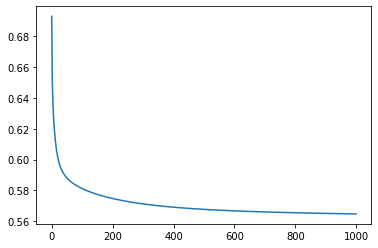

In [57]:
#Checking loss
plt.plot(loss_list);

In [58]:
def accuracy_func(feature_matrix, target_matrix, weights):
    
    one_column = np.ones((feature_matrix.shape[0],1))
    feature_matrix = np.concatenate([one_column, feature_matrix ], axis = 1)
    
    lin_pred = feature_matrix@weights
    class_pred = 1/ (1 + np.exp(-lin_pred))
    class_pred = np.around(class_pred)

    score = 0
        
    for idx in range(0,len(class_pred)):
        val = target_matrix[idx]
        pred = class_pred[idx]

        if val == pred:
            score += 1

    accuracy = score/len(class_pred)
    
    return(class_pred, accuracy)

pred, accuracy = accuracy_func(feature_matrix, target_matrix, weights)
accuracy

0.7204780420628412

## Part iii)

### Retrieving unique words in the dev set via cosine similarity

In [60]:
dev_claim_dicts = []
claims_4 = []
claim_string_4 = []

ten_claims = [137334, 111897, 89891, 181634, 219028, 108281, 204361, 54168, 105095, 18708]

with open('data_files/shared_task_dev.jsonl') as openfile:
        for iline, line in enumerate(openfile.readlines()):
        
            claim_dic = json.loads(line)
            ID = claim_dic['id']
            
            if ID in ten_claims:
                claim_string_4.append(claim_dic['claim'])
                
                dev_claim_dicts.append(claim_dic)
                text = claim_dic['claim'].lower()
                tokens = tokenizer.tokenize(text)
                
                claims_4.append(tokens)

                
#All claim words
all_words_4 = []

for claim in claims_4:
    for word in claim:
        all_words_4.append(word)
        
#Removing stop words from claims
stop_words = set(stopwords.words('english')) 
stemmer = PorterStemmer()

all_words_4 = [word for word in all_words_4 if not word in stop_words] 
all_words_4 = [stemmer.stem(word) for word in all_words_4]

all_words_4 = list(set(all_words_4))
all_words_4.sort()

In [61]:
len(all_words_4)

44

### Constructing tf-idf matrix to retrieve documents for 10 claims

In [64]:
#Constructing tf-matrix for the 10 claims that need to be verified

tf_matrix_4 = np.zeros((total_doc, len(all_words_4)))
current_doc = 0

brackets = ['lrb', 'rrb', 'lsb', 'rsb', 'rcb', 'lcb']

for file in tqdm(list_of_wiki, position = 0, leave = True):
        with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
                for iline,line in enumerate(openfile.readlines()):
                    
                    text = json.loads(line)['text']
                    text = text.lower()
                    tokens = tokenizer.tokenize(text)
                    
                    #Removing stop words
                    tokens = [word for word in tokens if not word in stop_words] 
                    
                    #Removing brackets manually
                    tokens = [word for word in tokens if not word in brackets] 
                    
                    #Stemming
                    tokens = [stemmer.stem(word) for word in tokens]
                    
                    #Count the words in documents
                    for ind,word in enumerate(all_words_4):
                        if word in set(tokens):
                            word_tf = tokens.count(word)/len(tokens)
                            tf_matrix_4[current_doc][ind] = word_tf
                                
                    current_doc += 1

100%|██████████| 109/109 [1:32:18<00:00, 50.81s/it]


In [65]:
file_path = "data_files/tf_matrix_4.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

bytes_out = pickle.dumps(tf_matrix_4)
with open(file_path, 'wb') as f_out:
    for idx in range(0, len(bytes_out), max_bytes):
        f_out.write(bytes_out[idx:idx+max_bytes])

In [66]:
file_path = "data_files/tf_matrix_4.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
tf_matrix_4 = pickle.loads(bytes_in)

In [67]:
#Making IDF matrix for question 4

#Counting number of documents with each term in it
idf_matrix_4 = np.zeros(len(all_words_4))

for index in range(0, len(all_words_4)):
    doc_count = np.count_nonzero(tf_matrix_4[:,index])
    idf_matrix_4[index] = math.log10(total_doc/doc_count)

In [68]:
tf_idf_4 = tf_matrix_4*idf_matrix_4

In [69]:
clean_claims_4 = []

stop_words = set(stopwords.words('english')) 
stemmer = PorterStemmer()

for claim in claims_4:
    clean_claim = [word for word in claim if not word in stop_words] 
    clean_claim = [stemmer.stem(word) for word in clean_claim]
    clean_claims_4.append(clean_claim)

In [70]:
#tf_idf for every claim
claims_tf_idfs_4 = []

for claim in clean_claims_4:
    claim_tf_4 = np.zeros(len(all_words_4))
    
    for idx, word in enumerate(all_words_4):
        claim_tf_4[idx] = claim.count(word)/len(claim)
            
    claim_tf_idf_4 = claim_tf_4*idf_matrix_4
    claims_tf_idfs_4.append(claim_tf_idf_4)
    
#Norm adjusting the matrices
norm_rows_docs_4 = []
norm_rows_claims_4 = []

for row in tf_idf_4:
    norm_doc = np.linalg.norm(row)
    norm_adj_row = row
    
    if norm_doc!= 0:
        norm_adj_row = norm_adj_row/norm_doc
    
    norm_rows_docs_4.append(norm_adj_row)
        
for claim in claims_tf_idfs_4:
    norm_claim = np.linalg.norm(claim)
    norm_adj_claim = claim/norm_claim
    norm_rows_claims_4.append(norm_adj_claim)
    
doc_norm_tf_idf_4 = np.array(norm_rows_docs_4)

#Retrieving 5 highest for each claim
top5_list_4 = []

for claim in norm_rows_claims_4:
    cosine_similarity = doc_norm_tf_idf_4@claim 
    highest_5_row = cosine_similarity.argsort()[-5:][::1]
    
    highest_5 = []
    for ind in highest_5_row:
        highest_5.append(ids[ind])
        
    highest_5.reverse()    
    top5_list_4.append(highest_5)

In [74]:
#Retrieving list of sentences for every document
rel_docs = merged = list(itertools.chain.from_iterable(top5_list_4))

### Finding all the sentences only in the retrieved documents

In [76]:
all_lines_dict = {}   #Creating a dictionry of all lines
number_of_lines = {}  #number of lines storing later for negative sampling irrelevant sentences

bracket_dict = {'-lrb-': '(', '-rrb-': ')', '-lsb-': '[', '-rsb-': ']', '-lcb': '{', 'rcb': '}'}

for file in tqdm(list_of_wiki, position = 0, leave = True):
        with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
                for iline,line in enumerate(openfile.readlines()):
                    iD = json.loads(line)['id']
                    
                    iD = unicodedata.normalize('NFC',iD)
                        
                    if iD in rel_docs:
           
                        doc_lines = json.loads(line)['lines']
                                                
                        doc_line_list = doc_lines.split('\n')
                        
                        number_of_lines[iD] = len(doc_line_list)
                                                                
                        for line_number in range(0, len(doc_line_list)):
                            doc_line = doc_line_list[line_number].lower()
                            
                            #Isolating cleaned up version of line
                            doc_line = doc_line.split('\t')[1]
                            doc_line = doc_line.split('.')[0]
                            
                            doc_line = doc_line.split(' ')
                            
                            #Sorting out the brackets
                            if len(doc_line) != 0:
                            
                                doc_line_brac = []
                                for word in doc_line:

                                    if word in set(list(bracket_dict.keys())):
                                        word = bracket_dict[word]

                                    doc_line_brac.append(word)

                                all_lines_dict[(iD, line_number)] = doc_line_brac

100%|██████████| 109/109 [00:55<00:00,  1.97it/s]


### Making a cleaned up representation of claims and retrieving evidence

In [77]:
claims = []
evidences = []

for dic in dev_claim_dicts:
    evidences.append(dic['evidence'])
    claim = dic['claim']
    claim = claim.lower()
    claim = claim[:-1]
    claim = claim.split(' ')
    
    no_apos_claim = []
    #Removing apostrophe for vector representation later
    for word in claim:
        if "'" in word:
            no_apos_claim.append(word[:-2])
            no_apos_claim.append("'s")
            
        else:
            no_apos_claim.append(word)
    
    claims.append(no_apos_claim)

### Dictionary mapping document to claim

In [78]:
doc_claim_mapper = {}

for idx,docs in enumerate(top5_list_4):
    for doc in docs:
        doc_claim_mapper[doc] = claims[idx]

### Cleaning up the evidence and making a list of relevant sentences

In [79]:
#Code block to retrieve relevant sentences

rel_sent = []
for evidence in evidences:
    for lst in evidence:
        for one in lst:
            rel_tuple = (one[2], one[3])
            rel_sent.append(rel_tuple)

rel_sent = list(set(rel_sent))

### Identifying which sentences cosine simlarity picked up

In [81]:
rel_search_sent = []

for sent in rel_sent:
    doc = sent[0]
    
    if doc in rel_docs:
        rel_search_sent.append(sent)

### Making a list of sentences to loop and populate 3 lists

In [83]:
all_sentences = list(all_lines_dict.items())

claim_list = []
sentence_list = []
target_list = []

for tup in all_sentences:
    
    #Find the claim
    doc = tup[0][0]
    claim = doc_claim_mapper[doc]
    claim_list.append(claim)
    
    #Find the sentence
    sentence = tup[1]
    sentence_list.append(sentence)
    
    #Find whether relevant or not
    check = tup[0]
    
    target = 0
    if check in rel_sent:
        target = 1
    target_list.append(target)

### Building Vector Representations


In [84]:
claim_arrays = []
sentence_arrays = []

for claim in claim_list:
    claim_array = np.zeros(50)
    for word in claim:
        claim_array += model[word]
    claim_arrays.append(claim_array)
    

for sentence in sentence_list:
    sentence_array = np.zeros(50)
    for word in sentence:
        try:
            sentence_array += model[word]
        except:
            pass
    sentence_arrays.append(sentence_array)
    
claim_matrix = np.array(claim_arrays)
sentence_matrix = np.array(sentence_arrays)
one_column = np.ones((len(claim_arrays),1))

#Making feature matrix
feature_matrix_dev = np.concatenate([one_column,claim_matrix, sentence_matrix], axis = 1)
target_matrix_dev = np.array(target_list)

### Making prediction on dev set

In [85]:
lin_pred = feature_matrix_dev@weights
class_pred = 1/ (1 + np.exp(-lin_pred))
class_pred = np.around(class_pred)

score = 0

for idx in range(0,len(class_pred)):
    val = target_matrix_dev[idx]
    pred = class_pred[idx]
    
    if val == pred:
        score += 1
        
accuracy = score/len(class_pred)
accuracy

0.78

# Question 5

### Creating test set for logistic regression in same manner as training set

In [89]:
#Recalling same code chunk from before but with shared_task_dev file via function
def pair_maker(filename):
    
    veri_claims = []
    veri_evid = []
    veri_label = []

    binary_claim_dic = {'SUPPORTS':1, 'REFUTES':0}

    with open(filename) as openfile:
            for iline, line in enumerate(openfile.readlines()):

                claim_dic = json.loads(line)
                veri_check = claim_dic['verifiable']

                if veri_check == 'VERIFIABLE':
                    claim = claim_dic['claim']
                    evidence = claim_dic['evidence']
                    label = binary_claim_dic[claim_dic['label']]

                    veri_claims.append(claim)
                    veri_evid.append(evidence)
                    veri_label.append(label)
                    
    one_line_claims = []
    one_line_evidence = []
    one_line_labels = []

    for idx, evid in enumerate(veri_evid):
        if len(evid[0]) == 1:
            one_line_evidence.append(evid)
            one_line_claims.append(veri_claims[idx])
            one_line_labels.append(veri_label[idx])

    clean_evidence = []
    
    for evidence in one_line_evidence:

        one_claim_list = []
        for each in evidence:
            one_evid = each[0]

            document = one_evid[2]
            line = one_evid[3]

            one_claim_list.append((document, line))

        clean_evidence.append(one_claim_list)


    #Making a dicitonary of all required articles and lines
    all_required_dict = {}

    for evidence in clean_evidence:

        key_val = unicodedata.normalize('NFC', evidence[0][0])

        for each in evidence:
            if key_val in all_required_dict:
                all_required_dict[key_val].append(each[1])
                all_required_dict[key_val] = list(set(all_required_dict[key_val]))

            else:
                all_required_dict[key_val] = [each[1]] 

    all_required_dict

    #Retrieving just the article titles
    all_required_articles = list(all_required_dict.keys())

    veri_lines_dict = {}
    number_of_lines = {}  #number of lines storing later for negative sampling irrelevant sentences

    bracket_dict = {'-lrb-': '(', '-rrb-': ')', '-lsb-': '[', '-rsb-': ']', '-lcb': '{', 'rcb': '}'}

    for file in tqdm(list_of_wiki, position = 0, leave = True):
            with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
                    for iline,line in enumerate(openfile.readlines()):
                        iD = json.loads(line)['id']

                        iD = unicodedata.normalize('NFC',iD)

                        if iD in all_required_dict:

                            doc_lines = json.loads(line)['lines']

                            doc_line_list = doc_lines.split('\n')

                            number_of_lines[iD] = len(doc_line_list)

                            for line_number in range(0, len(doc_line_list)):
                                doc_line = doc_line_list[line_number].lower()

                                #Isolating cleaned up version of line
                                doc_line = doc_line.split('\t')[1]
                                doc_line = doc_line.split('.')[0]

                                doc_line = doc_line.split(' ')

                                #Sorting out the brackets
                                doc_line_brac = []
                                for word in doc_line:

                                    if word in set(list(bracket_dict.keys())):
                                        word = bracket_dict[word]

                                    doc_line_brac.append(word)

                                veri_lines_dict[(iD, line_number)] = doc_line_brac

    neg_sample_list= []

    for evidence in clean_evidence:
        evid_dict = {}

        for each_evid in evidence:
            document = each_evid[0]
            document = unicodedata.normalize('NFC',document)

            rel_line = each_evid[1]

            #Creating a dictionary with all
            if document in evid_dict:
                evid_dict[document].append(rel_line)
                evid_dict[document] = list(set(evid_dict[document]))

            else:
                evid_dict[document]  = [rel_line]

        try:
            total_sentences = number_of_lines[document]

            sample_list = list(range(0,total_sentences))
            sample_list = [number for number in sample_list if not number in evid_dict[document]]

        except:
            sample_list = 'doc not found'

        neg_sample_list.append((document, sample_list))

    actual_lines_evidence = []

    for evidence in clean_evidence:
        sub_list =[]

        for each in evidence:
            each = (unicodedata.normalize('NFC',each[0]), each[1])

            actual_line = veri_lines_dict[each]
            actual_line = actual_line[:-1]
            sub_list.append(actual_line)

        actual_lines_evidence.append(sub_list)

    #Creating equivalent negative sample for every claim
    neg_lines_evidence = []

    for idx, evidence in enumerate(clean_evidence):
        neg_sub_list =[]

        for each in evidence:

            neg_sample_numbers = neg_sample_list[idx][1]
            neg_line_number = random.choice(neg_sample_numbers)

            each = (unicodedata.normalize('NFC',each[0]), neg_line_number)
            neg_line = veri_lines_dict[each]

            #while loop to avoid empty list
            while len(neg_line) == 0:
                neg_line_number = random.choice(neg_sample_numbers)
                each = (unicodedata.normalize('NFC',each[0]), neg_line_number)
                neg_line = veri_lines_dict[each]

            neg_line = neg_line[:-1]
            neg_sub_list.append(neg_line)

        neg_lines_evidence.append(neg_sub_list)

    #tokenise the claims

    one_line_tokenised = []

    for claim in one_line_claims:
        no_stop = claim[:-1]
        lower_claim = no_stop.lower()
        tokenised = lower_claim.split(' ')
        one_line_tokenised.append(tokenised)

    #Create verifiable tuples
    pos_claim_evidence = []
    neg_claim_evidence = []

    for idx,evidence in enumerate(actual_lines_evidence):
        for each in evidence:
            veri_tuples = (one_line_tokenised[idx], each)
            pos_claim_evidence.append(veri_tuples)

    for idx, evidence in enumerate(neg_lines_evidence):
        for each in evidence:
            neg_tuples = (one_line_tokenised[idx], each)
            neg_claim_evidence.append(neg_tuples)
            
    return(pos_claim_evidence, neg_claim_evidence)

pos_claim_5, neg_claim_5 = pair_maker('data_files/shared_task_dev.jsonl')

100%|██████████| 109/109 [00:51<00:00,  2.11it/s]


### Creating arrays

In [91]:
#Making representation arrays
verif_arrays_5 = []

for pair in tqdm(pos_claim_5, position = 0, leave = True):
    claim = pair[0]
    claim_array = np.zeros(50)
    for word in claim:
        try:
            claim_array += model[word]
        except:
            pass
            
    evidence = pair[1]
    evidence_array = np.zeros(50)
    for word in evidence:
        try:
            evidence_array += model[word]
        except:
            pass

    array_row = np.concatenate([claim_array, evidence_array])
    
    verif_arrays_5.append(array_row)
    
#Making representation arrays
neg_arrays_5 = []

for pair in tqdm(neg_claim_5, position = 0, leave = True):
    claim = pair[0]
    claim_array = np.zeros(50)
    for word in claim:
        try:
            claim_array += model[word]
        except:
            pass
            
    evidence = pair[1]
    evidence_array = np.zeros(50)
    for word in evidence:
        try:
            evidence_array += model[word]
        except:
            pass

    array_row = np.concatenate([claim_array, evidence_array])
    
    neg_arrays_5.append(array_row)

100%|██████████| 22556/22556 [00:00<00:00, 32592.65it/s]


In [92]:
veri_matrix_5 = np.array(verif_arrays_5)
neg_matrix_5 = np.array(neg_arrays_5)
rel_y5 = np.ones(len(verif_arrays_5))
neg_y5 = np.zeros(len(neg_arrays_5))
feature_matrix_5 = np.concatenate((veri_matrix_5,neg_matrix_5), axis=0)
target_matrix_5 = np.concatenate((rel_y5,neg_y5), axis=0)

### Calculting relevant metrics

In [93]:
def accuracy_func(feature_matrix, target_matrix, weights):
    
    one_column = np.ones((feature_matrix.shape[0],1))
    feature_matrix = np.concatenate([one_column, feature_matrix], axis = 1)
    
    lin_pred = feature_matrix@weights
    class_pred = 1/ (1 + np.exp(-lin_pred))
    class_pred = np.around(class_pred)

    score = 0
        
    for idx in range(0,len(class_pred)):
        val = target_matrix[idx]
        pred = class_pred[idx]

        if val == pred:
            score += 1

    accuracy = score/len(class_pred)
    
    return(class_pred, accuracy)

In [94]:
preds, acc = accuracy_func(feature_matrix_5, target_matrix_5, weights)

In [95]:
#Precision
all_data = len(preds)

numer = 0
denom = 0
for i in range(0, all_data):
    if preds[i] == 1:    #Checks if retrieved
        denom += 1
        
    if (preds[i] == 1) and (target_matrix_5[i] == 1):  #Actual correct claims retrieved
        numer += 1
        
precision = numer/denom

In [96]:
#Calculating recall

numer = 0
denom = 0
for i in range(0, all_data):
    if target_matrix_5[i] == 1:    #Total relevant
        denom += 1
        
    if (preds[i] == 1) and (target_matrix_5[i] == 1):  #Correctly retrieved
        numer += 1
    
recall = numer/denom

In [97]:
#F1 Score
F1 = 2*(precision*recall)/(precision+recall)

# Question 6

### Creating feature and target matrices then actual model for 6 and 8 are built on separate files labelled Question 6 and Question 8

In [98]:
def mapper6(filename):
    
    veri_claims = []
    veri_evid = []
    veri_label = []


    with open(filename) as openfile:
                for iline, line in enumerate(openfile.readlines()):

                    claim_dic = json.loads(line)
                    veri_check = claim_dic['verifiable']

                    if veri_check == 'VERIFIABLE':
                        claim = claim_dic['claim']
                        evidence = claim_dic['evidence']
                        label = binary_claim_dic[claim_dic['label']]

                        veri_claims.append(claim)
                        veri_evid.append(evidence)
                        veri_label.append(label)

    one_line_claims = []
    one_line_evidence = []
    one_line_labels = []

    for idx, evid in enumerate(veri_evid):
        if len(evid[0]) == 1:
            one_line_evidence.append(evid)
            one_line_claims.append(veri_claims[idx])
            one_line_labels.append(veri_label[idx])

    clean_evidence = []

    for evidence in one_line_evidence:

        one_claim_list = []
        for each in evidence:
            one_evid = each[0]

            document = one_evid[2]
            line = one_evid[3]

            one_claim_list.append((document, line))

        clean_evidence.append(one_claim_list)

    all_required_dict = {}

    for evidence in clean_evidence:

        key_val = unicodedata.normalize('NFC', evidence[0][0])

        for each in evidence:
            if key_val in all_required_dict:
                all_required_dict[key_val].append(each[1])
                all_required_dict[key_val] = list(set(all_required_dict[key_val]))

            else:
                all_required_dict[key_val] = [each[1]] 


    #Retrieving just the article titles
    all_required_articles = list(all_required_dict.keys())

    veri_lines_dict = {}

    bracket_dict = {'-lrb-': '(', '-rrb-': ')', '-lsb-': '[', '-rsb-': ']', '-lcb': '{', 'rcb': '}'}

    for file in tqdm(list_of_wiki, position = 0, leave = True):
            with open('data_files/wiki-pages/wiki-pages/' + file, 'r') as openfile:
                    for iline,line in enumerate(openfile.readlines()):
                        iD = json.loads(line)['id']

                        iD = unicodedata.normalize('NFC',iD)

                        if iD in all_required_dict:

                            doc_lines = json.loads(line)['lines']

                            doc_line_list = doc_lines.split('\n')

                            number_of_lines[iD] = len(doc_line_list)

                            for line_number in range(0, len(doc_line_list)):
                                doc_line = doc_line_list[line_number].lower()

                                #Isolating cleaned up version of line
                                doc_line = doc_line.split('\t')[1]
                                doc_line = doc_line.split('.')[0]

                                doc_line = doc_line.split(' ')

                                #Sorting out the brackets
                                doc_line_brac = []
                                for word in doc_line:

                                    if word in set(list(bracket_dict.keys())):
                                        word = bracket_dict[word]

                                    doc_line_brac.append(word)

                                veri_lines_dict[(iD, line_number)] = doc_line_brac

    actual_lines_evidence = []

    for evidence in clean_evidence:
        sub_list =[]

        for each in evidence:
            each = (unicodedata.normalize('NFC',each[0]), each[1])

            actual_line = veri_lines_dict[each]
            actual_line = actual_line[:-1]
            sub_list.append(actual_line)

        actual_lines_evidence.append(sub_list)

    one_line_tokenised = []

    #Claims have a lot of 's so need modification to claim
    for claim in one_line_claims:
        no_stop = claim[:-1]
        lower_claim = no_stop.lower()
        tokenised = lower_claim.split(' ')

        one_line_tokenised.append(tokenised)

    clean_claims = []
    for claim in one_line_claims:   
        claim = claim.lower()
        no_stop = claim[:-1]
        claim = claim.split(' ')

        no_apos_claim = []
        #Removing apostrophe for vector representation later
        for word in claim:
            if "'" in word:
                no_apos_claim.append(word[:-2])
                no_apos_claim.append("'s")

            else:
                no_apos_claim.append(word)

        clean_claims.append(no_apos_claim)

    clean_claims = []
    for claim in one_line_claims:   
        claim = claim.lower()
        no_stop = claim[:-1]
        claim = claim.split(' ')

        no_apos_claim = []
        #Removing apostrophe for vector representation later
        for word in claim:
            if "'" in word:
                no_apos_claim.append(word[:-2])
                no_apos_claim.append("'s")

            else:
                no_apos_claim.append(word)

        clean_claims.append(no_apos_claim)

    pair_claims = []
    pair_evid = []
    pair_label = []

    for idx, sentences in enumerate(actual_lines_evidence):
        for sentence in sentences:
            pair_evid.append(sentence)
            pair_claims.append(clean_claims[idx])
            pair_label.append(one_line_labels[idx])
            
    return(pair_claims, pair_evid, pair_label)

In [99]:
claims6, evid6, label6 = mapper6('data_files/train.jsonl')

100%|██████████| 109/109 [00:53<00:00,  2.04it/s]


In [100]:
pickle.dump(claims6, open("pkl_files/claims6.p", "wb"))
pickle.dump(evid6, open("pkl_files/evid6.p", "wb"))
pickle.dump(label6, open("pkl_files/label6.p", "wb"))

In [101]:
claimstest, evidtest, labeltest = mapper6('data_files/shared_task_dev.jsonl')

100%|██████████| 109/109 [00:53<00:00,  2.03it/s]


In [102]:
pickle.dump(claimstest, open("pkl_files/claimstest.p", "wb"))
pickle.dump(evidtest, open("pkl_files/evidtest.p", "wb"))
pickle.dump(labeltest, open("pkl_files/labeltest.p", "wb"))

### See files Question 6 and 8 for continuation

### Appendix: Code to make json file

In [143]:
def json_extractor(filename):
    
    veri_id = []
    veri_evid = []


    with open(filename) as openfile:
                for iline, line in enumerate(openfile.readlines()):

                    claim_dic = json.loads(line)
                    veri_check = claim_dic['verifiable']

                    if veri_check == 'VERIFIABLE':
                        veri_id.append(claim_dic['id'])
                        veri_evid.append(claim_dic['evidence'])
                        

    
    one_line_evidence = []
    one_line_id = []

    for idx, evid in enumerate(veri_evid):
        if len(evid[0]) == 1:
            one_line_evidence.append(evid)
            one_line_id.append(veri_id[idx])
            
    clean_evidence = []

    for evidence in one_line_evidence:

        one_claim_list = []
        for each in evidence:
            one_evid = each[0]

            document = one_evid[2]
            line = one_evid[3]

            one_claim_list.append((document, line))

        clean_evidence.append(one_claim_list)
        
    pair_evidence = []
    pair_iD = []

    for idx, evidences in enumerate(clean_evidence):
        for evid in evidences:
            pair_evidence.append(evid)
            pair_iD.append(one_line_id[idx])
            
    return(pair_evidence, pair_iD)
                        
json_evidence, json_iD= json_extractor('data_files/shared_task_dev.jsonl')

In [150]:
final_pred = pickle.load( open( "pkl_files/final_predictions.p", "rb" ) )
bo_final_pred = ['SUPPORTS' if x == True else "REFUTES" for x in final_pred]

In [151]:
list_of_dics = []

for idx,ID in enumerate(json_iD):
    temp_dic = {}
    temp_dic["id"] = json_iD[idx]
    temp_dic["predicted_label"] = bo_final_pred[idx]
    temp_dic["evidence"] = json_evidence[idx]
    
    list_of_dics.append(temp_dic)

In [ ]:
unique_dics = []

for i in range(0, len(list_of_dics)):
    if list_of_dics[i] not in list_of_dics[i+1:]:
        unique_dics.append(list_of_dics[i])

In [147]:
output_file = "predictions.jsonl"

json_objects = []

for dic in unique_dics:
    json_objects.append(json.dumps(dic))
line = "\n".join(json_objects)

with open(output_file, "w") as outfile:
    outfile.write(line)